In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Fit H2O Model

In [3]:
# H2O ML MODEL ======================================================================================================================
# preproc ===========================
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# init ==============================
h2o.init(max_mem_size='14G')

# import data =======================
train = h2o.import_file("../input/ashrae-stack-set-train-fin/train.csv", header=1)

y = "target"
x = train.columns[0:20]

# fit model =========================
glm_model = H2OGeneralizedLinearEstimator(
    family="gaussian", 
    solver='AUTO', 
    alpha=0.5,
    #lambda=0.0,
    link='Family_Default',
    intercept=True,
    lambda_search=True, 
    nlambdas=100, 
    missing_values_handling='MeanImputation',
    standardize=True,
    #nfolds = 5, 
    seed = 1333
)
glm_model.train(x=x, y=y, training_frame=train)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-8u232-b09-1~deb9u1-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmposd4uebl
  JVM stdout: /tmp/tmposd4uebl/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmposd4uebl/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,2 months and 1 day
H2O cluster name:,H2O_from_python_unknownUser_xlk597
H2O cluster total nodes:,1
H2O cluster free memory:,12.44 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


In [4]:
# Eval mod ==========================
#glm_model.rmse(xval=True)

In [5]:
# release memory and load test ========
h2o.remove(train)
del train
gc.collect()

87

In [6]:
# Model pred ========================
test = h2o.import_file("../input/ashrae-stack-set-test-fin/test.csv", header=1)
preds = glm_model.predict(test).as_data_frame()

# release memory and load test ========
h2o.remove(test)
del test
gc.collect()

h2o.cluster().shutdown()

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
H2O session _sid_a030 closed.


In [7]:
#preds.to_csv(preds, 'preds.csv', index=False, float_format='%.4f')

## Link and out subm

In [8]:
%%time

test_df = pd.read_csv('../input/ashrae-energy-prediction/test.csv', parse_dates=["timestamp"])
building_meta_df = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')

CPU times: user 30.8 s, sys: 3.32 s, total: 34.1 s
Wall time: 33.6 s


In [9]:
# leak data
leak_df = pd.read_feather('../input/ashrae-leak-data-station/leak.feather')

leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



In [10]:
test_df['pred'] = np.expm1(preds['predict'])
test_df.loc[test_df.pred<0, 'pred'] = 0

test_df = reduce_mem_usage(test_df)
leak_df = reduce_mem_usage(leak_df)

Memory usage of dataframe is 1590.64 MB
Memory usage after optimization is: 755.55 MB
Decreased by 52.5%
Memory usage of dataframe is 455.38 MB
Memory usage after optimization is: 296.00 MB
Decreased by 35.0%


In [11]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred','row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')

# Submit

In [12]:
sample_submission = pd.read_csv('../input/ashrae-energy-prediction/sample_submission.csv')
sample_submission['meter_reading'] = test_df.pred
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

In [13]:
sample_submission.head()

,row_id,meter_reading
0,0,165.986603
1,1,78.986931
2,2,8.708368
3,3,253.124786
4,4,1049.931396


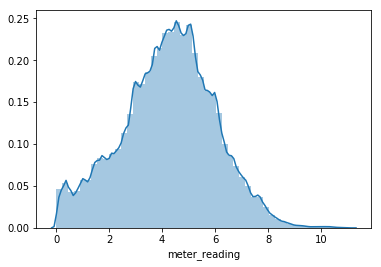

In [14]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [15]:
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

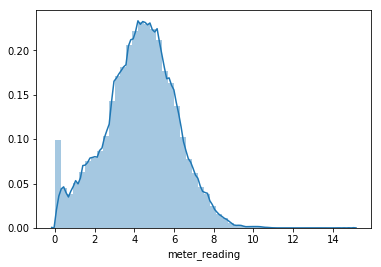

In [16]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [17]:
sample_submission.head()

,row_id,meter_reading
0,0,173.370300
1,1,53.512718
2,2,6.143042
3,3,101.701469
4,4,1141.240723


In [18]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')